In [1]:
#Data Analysis
import pandas as pd
import numpy as np
# Modeling
import statsmodels.api as sm
from pygam import GAM, ExpectileGAM, s, f
from sklearn.preprocessing import LabelEncoder
# Visualization
import plotly.express as px
from plotnine import *
import pytimetk as tk
import textwrap 
import matplotlib.pyplot as plt
from sklearn.metrics import r2_score, mean_squared_error, mean_absolute_error

In [2]:
data_pred = pd.read_excel('data_pred.xlsx')

In [3]:
data_pred

,arrival day,type de chambre,booking lead,is-week-end,res day,season,arr month,arr day,is_promo,taux occ arr,nbre res,paid price,rev par type de chambre,event,pred_q0.025,pred_q0.5,pred_q0.975
0,2024-01-01,single,2,False,2023-12-30,winter,1,1,False,0.36,144,728.13,97643.77,no_promo,124.368396,139.183923,166.975651
1,2024-01-01,single,62,False,2023-10-31,winter,1,1,False,0.36,144,676.01,97643.77,no_promo,124.932669,141.352999,173.010672
2,2024-01-01,single,71,False,2023-10-22,winter,1,1,False,0.36,144,667.57,97643.77,no_promo,131.622044,166.973633,210.676371
3,2024-01-01,single,49,False,2023-11-13,winter,1,1,True,0.36,144,639.01,97643.77,is_promo,125.844812,145.770657,182.286368
4,2024-01-01,single,0,False,2024-01-01,winter,1,1,False,0.36,144,722.32,97643.77,no_promo,126.174469,148.988993,187.222608
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
267970,2025-06-30,family,80,False,2025-04-11,summer,6,30,False,0.35,70,1465.57,104947.60,no_promo,67.922484,87.055776,108.031225
267971,2025-06-30,family,12,False,2025-06-18,summer,6,30,False,0.35,70,1592.27,104947.60,no_promo,62.731404,72.875287,91.672242
267972,2025-06-30,family,6,False,2025-06-24,summer,6,30,True,0.35,70,1468.10,104947.60,is_promo,64.501180,77.846902,96.764855
267973,2025-06-30,family,5,False,2025-06-25,summer,6,30,True,0.35,70,1470.13,104947.60,is_promo,64.104430,76.835593,95.187637


### ajout des colonnes rev

In [4]:
data_pred['rev__q0.025'] = data_pred['pred_q0.025'] * data_pred['paid price']
data_pred['rev__q0.5']   = data_pred['pred_q0.5']   * data_pred['paid price']
data_pred['rev__q0.975'] = data_pred['pred_q0.975'] * data_pred['paid price']

### ajout des colonnes moyennes des revenues

In [5]:
data_pred['rev__q0.025_m'] = data_pred.groupby(['arrival day', 'type de chambre'])['rev__q0.025'].transform('mean')
data_pred['rev__q0.5_m']   = data_pred.groupby(['arrival day', 'type de chambre'])['rev__q0.5'].transform('mean')
data_pred['rev__0.975_m']  = data_pred.groupby(['arrival day', 'type de chambre'])['rev__q0.975'].transform('mean')

In [6]:
data_pred

,arrival day,type de chambre,booking lead,is-week-end,res day,season,arr month,arr day,is_promo,taux occ arr,...,event,pred_q0.025,pred_q0.5,pred_q0.975,rev__q0.025,rev__q0.5,rev__q0.975,rev__q0.025_m,rev__q0.5_m,rev__0.975_m
0,2024-01-01,single,2,False,2023-12-30,winter,1,1,False,0.36,...,no_promo,124.368396,139.183923,166.975651,90556.360418,101343.990023,121579.980603,90890.448112,111088.488031,135951.272189
1,2024-01-01,single,62,False,2023-10-31,winter,1,1,False,0.36,...,no_promo,124.932669,141.352999,173.010672,84455.733538,95556.040673,116956.944154,90890.448112,111088.488031,135951.272189
2,2024-01-01,single,71,False,2023-10-22,winter,1,1,False,0.36,...,no_promo,131.622044,166.973633,210.676371,87866.928103,111466.588096,140641.224928,90890.448112,111088.488031,135951.272189
3,2024-01-01,single,49,False,2023-11-13,winter,1,1,True,0.36,...,is_promo,125.844812,145.770657,182.286368,80416.093195,93148.907295,116482.812068,90890.448112,111088.488031,135951.272189
4,2024-01-01,single,0,False,2024-01-01,winter,1,1,False,0.36,...,no_promo,126.174469,148.988993,187.222608,91138.342315,107617.729210,135234.634181,90890.448112,111088.488031,135951.272189
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
267970,2025-06-30,family,80,False,2025-04-11,summer,6,30,False,0.35,...,no_promo,67.922484,87.055776,108.031225,99545.154183,127586.333131,158327.322844,100972.358927,124426.187432,152670.130987
267971,2025-06-30,family,12,False,2025-06-18,summer,6,30,False,0.35,...,no_promo,62.731404,72.875287,91.672242,99885.333427,116037.133709,145966.960623,100972.358927,124426.187432,152670.130987
267972,2025-06-30,family,6,False,2025-06-24,summer,6,30,True,0.35,...,is_promo,64.501180,77.846902,96.764855,94694.181637,114287.037200,142060.483299,100972.358927,124426.187432,152670.130987
267973,2025-06-30,family,5,False,2025-06-25,summer,6,30,True,0.35,...,is_promo,64.104430,76.835593,95.187637,94241.846306,112958.310287,139938.201312,100972.358927,124426.187432,152670.130987


In [7]:
data_pred.to_excel("dat_rev_mean.xlsx", index=False)

### data selection

In [38]:
data_filtered2 = (
    data_pred[
        (data_pred['arr month'].isin([2, 3, 4])) &
        #(data_try['type de chambre'] == 'single') &
        (data_pred['event'] == 'no_promo') &
        (data_pred['booking lead'] <= 10)
    ]
    .drop_duplicates(subset=['arrival day', 'type de chambre'], keep='first')
)


X1 = data_filtered2[['paid price']]
y1= data_filtered2['nbre res']

print(len(X1)) 

381


### curves smoothing

In [8]:
from statsmodels.nonparametric.smoothers_lowess import lowess

In [39]:

# Trier les données par paid price
data_filtered = data_filtered2.sort_values('paid price')

# Lissage LOWESS pour chaque type de chambre
def smooth_group(df, ycol):
    smoothed = lowess(df[ycol], df['paid price'], frac=0.3, return_sorted=False)
    return smoothed

# Appliquer le lissage à chaque groupe
data_filtered['rev__q0.5_smooth'] = data_filtered.groupby('type de chambre', group_keys=False)\
    .apply(lambda g: pd.Series(smooth_group(g, 'rev__q0.5_m'), index=g.index))\
    .sort_index()

data_filtered['rev__q0.025_smooth'] = data_filtered.groupby('type de chambre', group_keys=False)\
    .apply(lambda g: pd.Series(smooth_group(g, 'rev__q0.025_m'), index=g.index))\
    .sort_index()

data_filtered['rev__0.975_smooth'] = data_filtered.groupby('type de chambre', group_keys=False)\
    .apply(lambda g: pd.Series(smooth_group(g, 'rev__0.975_m'), index=g.index))\
    .sort_index()


In [42]:
data_filtered

,arrival day,type de chambre,booking lead,is-week-end,res day,season,arr month,arr day,is_promo,taux occ arr,...,pred_q0.975,rev__q0.025,rev__q0.5,rev__q0.975,rev__q0.025_m,rev__q0.5_m,rev__0.975_m,rev__q0.5_smooth,rev__q0.025_smooth,rev__0.975_smooth
41969,2024-03-27,single,10,False,2024-03-17,printemps,3,27,False,0.95,...,395.558648,232006.154313,252879.163367,261590.844828,202029.442012,228792.183317,247458.806342,230455.357675,204004.436489,248307.923078
198504,2025-02-18,single,10,False,2025-02-08,winter,2,18,False,0.95,...,392.848166,226962.336879,250350.413954,263447.908789,202690.253948,228935.046148,247334.503686,227529.674288,200905.180672,246714.418481
216216,2025-03-19,single,10,False,2025-03-09,printemps,3,19,False,0.95,...,391.670732,223876.481398,248758.447608,263245.815789,200342.136869,227728.472441,247040.858226,227244.449875,200649.229829,246540.718478
62201,2024-04-29,single,9,False,2024-04-20,printemps,4,29,False,0.96,...,388.833383,217096.313540,244611.172577,262384.766524,201810.822983,228287.357616,247521.911971,226102.170560,199368.895965,245943.133689
214671,2025-03-17,single,4,False,2025-03-13,printemps,3,17,False,0.90,...,388.287619,215723.170631,243771.644663,262202.863215,192998.701939,221692.415168,243675.767217,225782.676622,198984.068407,245787.275562
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
21303,2024-02-21,family,6,False,2024-02-15,winter,2,21,False,0.52,...,123.389261,161059.823005,173371.529162,194215.930732,157784.799769,177953.129906,205089.397492,180563.455033,159299.194956,208341.182363
213915,2025-03-14,family,5,False,2025-03-09,printemps,3,14,False,0.55,...,123.111675,161055.838374,173210.984737,193835.638977,160648.517259,181851.898160,209623.038534,180423.560468,159230.084027,208170.598282
231544,2025-04-15,family,1,False,2025-04-14,printemps,4,15,False,0.56,...,120.837973,161085.732749,172066.365470,190720.989449,158786.935250,180225.210973,208628.748445,179277.593523,158663.448376,206778.294864
200255,2025-02-20,family,1,False,2025-02-19,winter,2,20,False,0.56,...,118.573718,161175.460919,171158.430514,187614.450746,160885.176480,185076.686544,215638.076688,178193.036336,158123.543611,205472.158678


### calcul du max de chaque quantile

In [44]:
# Cas médian
best_50 = data_filtered.groupby('type de chambre', group_keys=False) \
    .apply(lambda x: x[x['rev__q0.5_smooth'] == x['rev__q0.5_smooth'].max()]) \
    .drop_duplicates(subset=['type de chambre']) \
    .reset_index(drop=True)

# Cas optimiste
best_975 = data_filtered.groupby('type de chambre', group_keys=False) \
    .apply(lambda x: x[x['rev__q0.025_smooth'] == x['rev__q0.025_smooth'].max()]) \
    .drop_duplicates(subset=['type de chambre']) \
    .reset_index(drop=True)

# Cas pessimiste
best_025 = data_filtered.groupby('type de chambre', group_keys=False) \
    .apply(lambda x: x[x['rev__0.975_smooth'] == x['rev__0.975_smooth'].max()]) \
    .drop_duplicates(subset=['type de chambre']) \
    .reset_index(drop=True)

In [45]:
best_50

,arrival day,type de chambre,booking lead,is-week-end,res day,season,arr month,arr day,is_promo,taux occ arr,...,pred_q0.975,rev__q0.025,rev__q0.5,rev__q0.975,rev__q0.025_m,rev__q0.5_m,rev__0.975_m,rev__q0.5_smooth,rev__q0.025_smooth,rev__0.975_smooth
0,2025-02-18,double,10,False,2025-02-08,winter,2,18,False,0.95,...,293.886092,281637.974037,316776.241531,335271.131736,256622.280936,291067.173202,316030.006071,296394.300137,263068.820062,318592.727149
1,2024-04-17,family,9,False,2024-04-08,printemps,4,17,False,0.95,...,197.037841,257456.098828,277033.367059,288605.265841,222993.724556,252567.555261,272892.224928,255726.705923,227066.625823,273704.726072
2,2024-03-27,single,10,False,2024-03-17,printemps,3,27,False,0.95,...,395.558648,232006.154313,252879.163367,261590.844828,202029.442012,228792.183317,247458.806342,230455.357675,204004.436489,248307.923078


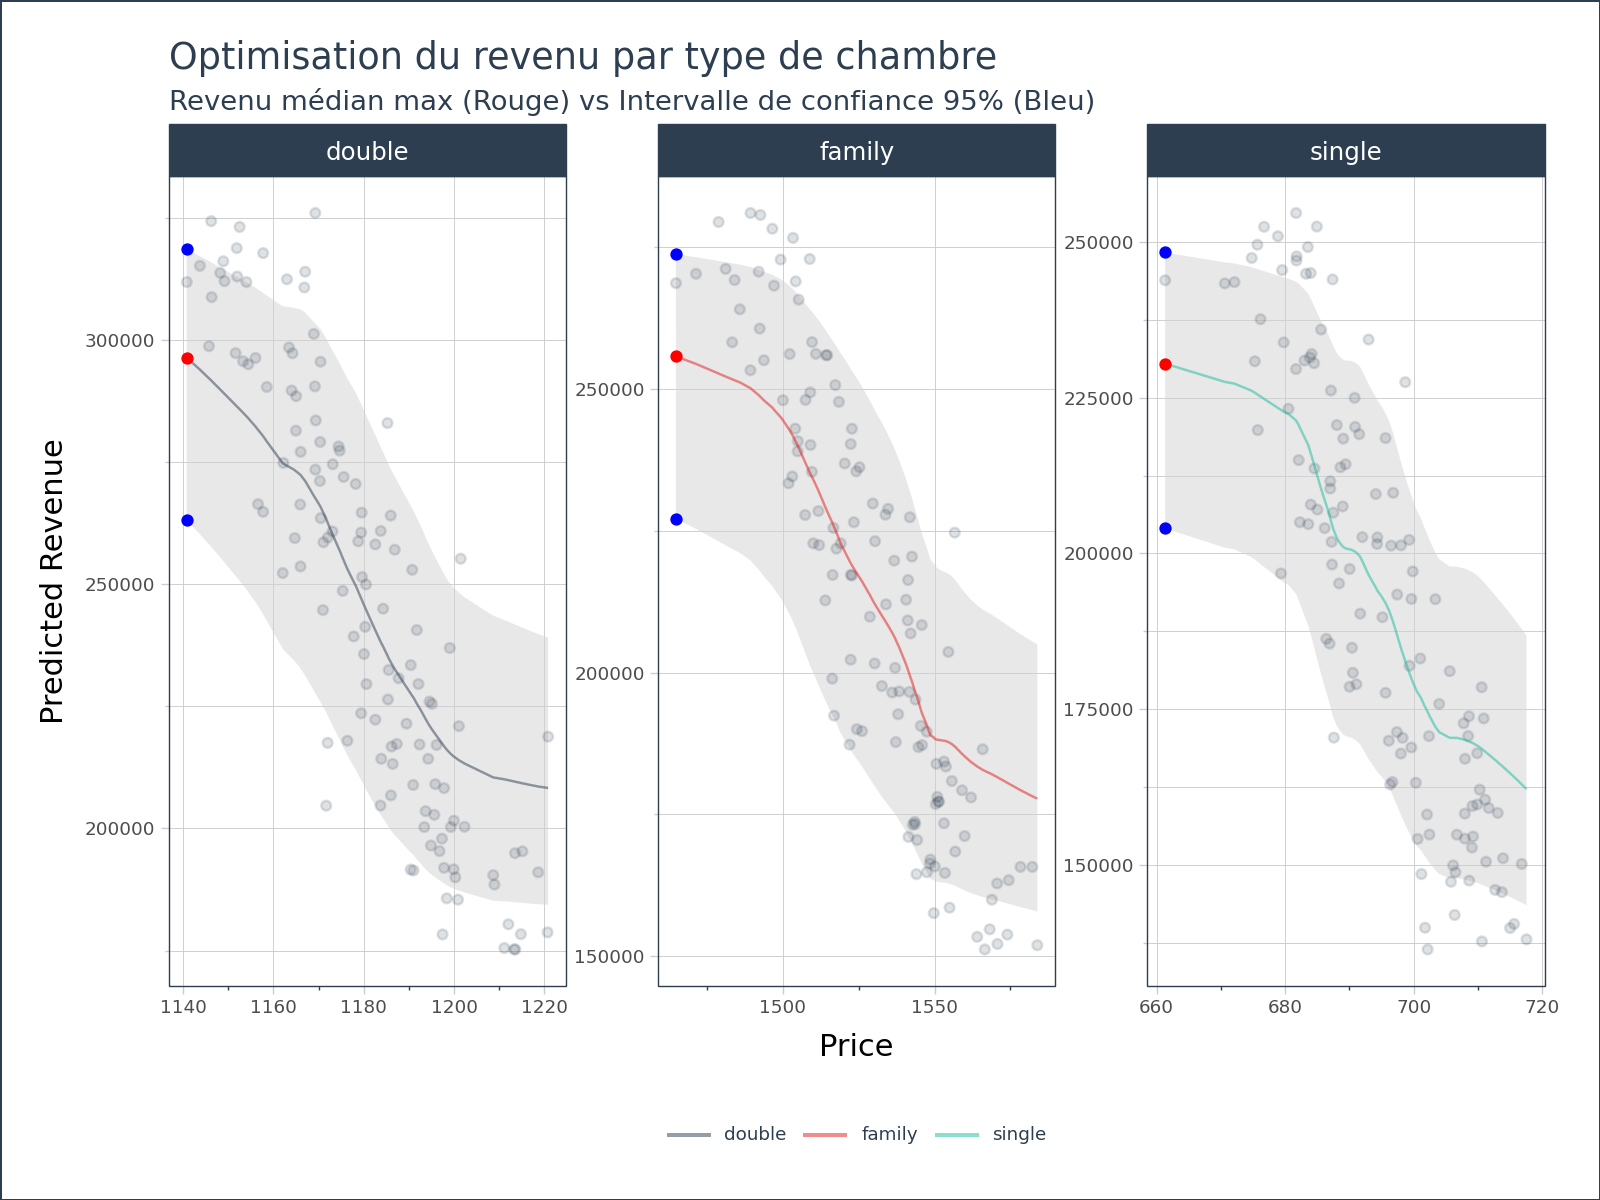

In [46]:
(
    ggplot(
        data=data_filtered,
        mapping=aes(x='paid price', y='rev__q0.5_smooth', color='type de chambre', group='type de chambre')
    ) + \
    geom_ribbon(aes(ymax='rev__0.975_smooth', ymin='rev__q0.025_smooth'),
                fill="#d3d3d3", color="#FF000000", alpha=0.5, show_legend=False) + \
    geom_point(aes(y='rev par type de chambre'), alpha=0.15, color="#2C3E50")+
    \
    geom_line(aes(y='rev__q0.5_smooth'), alpha=0.5) + \
    geom_point(data=best_50, color='red') + \
    geom_point(data=best_975, mapping=aes(y='rev__0.975_smooth'), color='blue') + \
    geom_point(data=best_025, mapping=aes(y='rev__q0.025_smooth'), color='blue') + \
    facet_wrap('type de chambre', scales='free') + \
    labs(
        title="Optimisation du revenu par type de chambre",
        subtitle="Revenu médian max (Rouge) vs Intervalle de confiance 95% (Bleu)",
        x="Price",
        y="Predicted Revenue"
    ) + \
    scale_color_manual(values = list(tk.palette_timetk().values())) + \
    tk.theme_timetk(width=800, height=600)
)

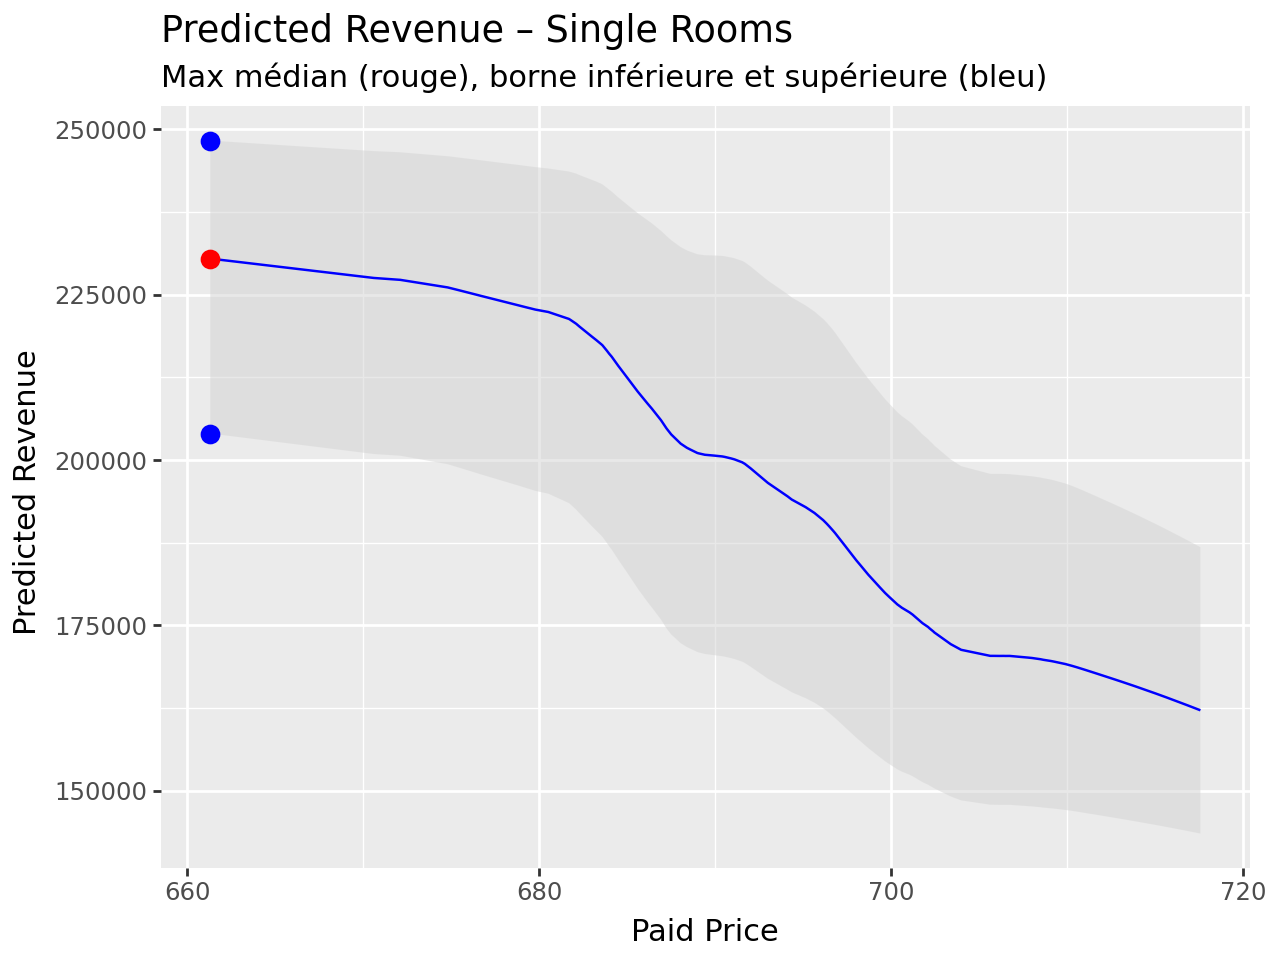

In [47]:
from statsmodels.nonparametric.smoothers_lowess import lowess
import numpy as np
import pandas as pd
from plotnine import *

# 1. Filtrer les chambres 'single'
data_single = data_filtered[data_filtered['type de chambre'] == 'single'].copy()

# 2. Trier
data_single = data_single.sort_values('paid price')

# 3. LOWESS smoothing
def smooth_group(df, ycol):
    smoothed = lowess(df[ycol], df['paid price'], frac=0.3, return_sorted=False)
    return smoothed

data_single['rev__q0.5_smoothed'] = smooth_group(data_single, 'rev__q0.5_m')
data_single['rev__q0.025_smoothed'] = smooth_group(data_single, 'rev__q0.025_m')
data_single['rev__0.975_smoothed'] = smooth_group(data_single, 'rev__0.975_m')

# 4. Best points (uniquement pour type de chambre == 'single')
best_50 = data_single.loc[[data_single['rev__q0.5_smoothed'].idxmax()]]
best_975 = data_single.loc[[data_single['rev__q0.025_smoothed'].idxmax()]]
best_025 = data_single.loc[[data_single['rev__0.975_smoothed'].idxmax()]]

# 5. Plot
(
    ggplot(data=data_single, mapping=aes(x='paid price', y='rev__q0.5_smoothed')) +
    geom_ribbon(
        aes(ymin='rev__q0.025_smoothed', ymax='rev__0.975_smoothed'),
        fill="#d3d3d3", alpha=0.5
    ) +
    geom_line(color='blue') +
    geom_point(data=best_50, color='red', size=3) +
    geom_point(data=best_975, mapping=aes(y='rev__q0.025_smoothed'), color='blue', size=3) +
    geom_point(data=best_025, mapping=aes(y='rev__0.975_smoothed'), color='blue', size=3) +
    labs(
        title="Predicted Revenue – Single Rooms",
        subtitle="Max médian (rouge), borne inférieure et supérieure (bleu)",
        x="Paid Price",
        y="Predicted Revenue "
    )
)


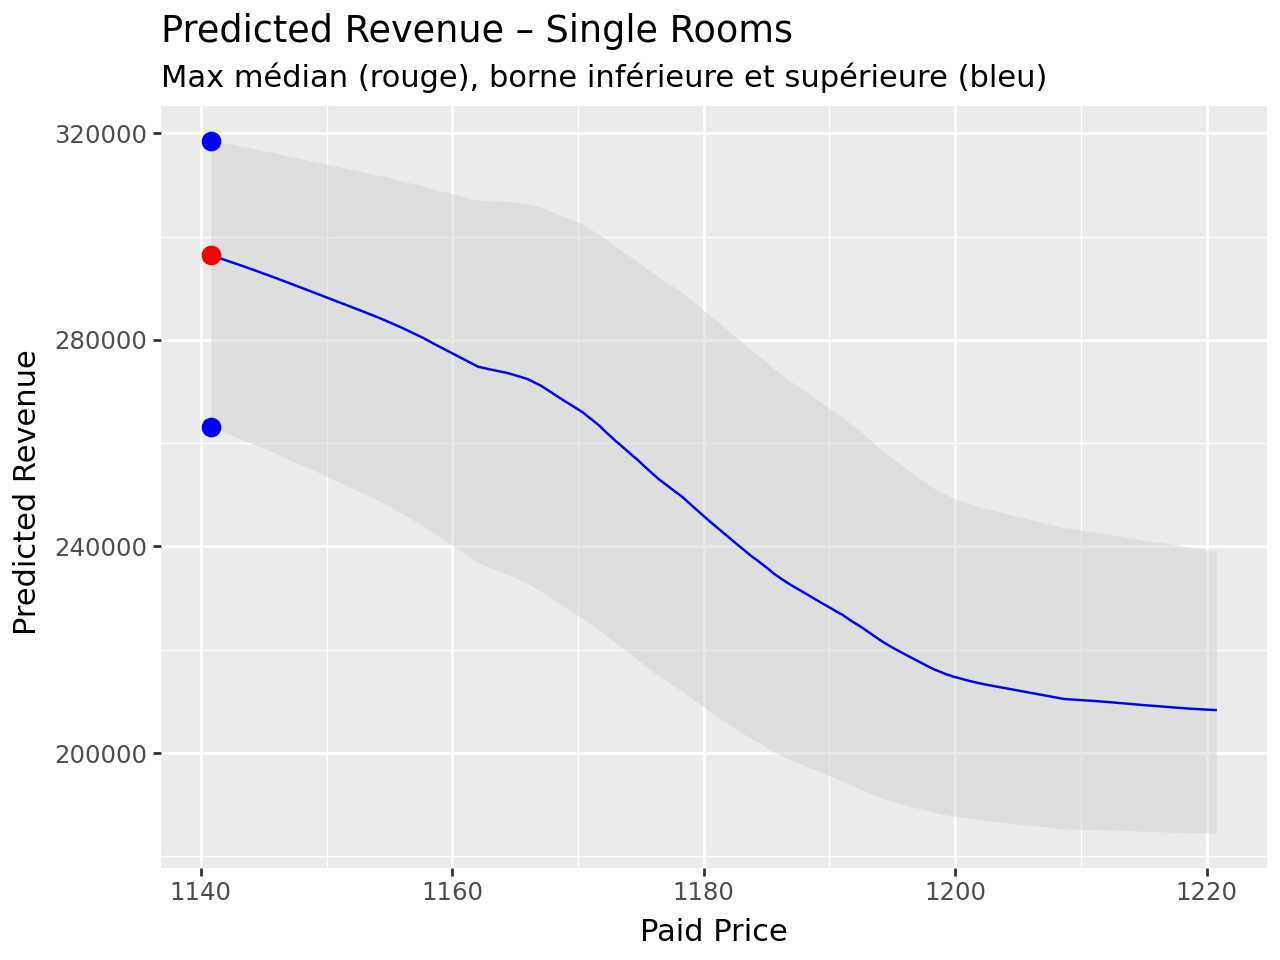

In [48]:
# 1. Filtrer les chambres 'double'
data_single = data_filtered[data_filtered['type de chambre'] == 'double'].copy()

# 2. Trier
data_single = data_single.sort_values('paid price')

# 3. LOWESS smoothing
def smooth_group(df, ycol):
    smoothed = lowess(df[ycol], df['paid price'], frac=0.3, return_sorted=False)
    return smoothed

data_single['rev__q0.5_smoothed'] = smooth_group(data_single, 'rev__q0.5_m')
data_single['rev__q0.025_smoothed'] = smooth_group(data_single, 'rev__q0.025_m')
data_single['rev__0.975_smoothed'] = smooth_group(data_single, 'rev__0.975_m')

# 4. Best points (uniquement pour type de chambre == 'single')
best_50 = data_single.loc[[data_single['rev__q0.5_smoothed'].idxmax()]]
best_975 = data_single.loc[[data_single['rev__q0.025_smoothed'].idxmax()]]
best_025 = data_single.loc[[data_single['rev__0.975_smoothed'].idxmax()]]

# 5. Plot
(
    ggplot(data=data_single, mapping=aes(x='paid price', y='rev__q0.5_smoothed')) +
    geom_ribbon(
        aes(ymin='rev__q0.025_smoothed', ymax='rev__0.975_smoothed'),
        fill="#d3d3d3", alpha=0.5
    ) +
    geom_line(color='blue') +
    geom_point(data=best_50, color='red', size=3) +
    geom_point(data=best_975, mapping=aes(y='rev__q0.025_smoothed'), color='blue', size=3) +
    geom_point(data=best_025, mapping=aes(y='rev__0.975_smoothed'), color='blue', size=3) +
    labs(
        title="Predicted Revenue – Single Rooms",
        subtitle="Max médian (rouge), borne inférieure et supérieure (bleu)",
        x="Paid Price",
        y="Predicted Revenue "
    )
)

In [49]:
data_filtered.to_excel("smoothed.xlsx", index=False)